In [454]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
from tqdm import tqdm
from scipy import stats
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# base paths/names
sess_names = np.load('sess_names.npy')
sess_name = sess_names[3]

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)


### Separate spike times by trials

Create a list of list that is N trials long w/ spike info from cpoke to endstate for each trial. 

**TODO** turn into function

In [204]:
test_neuron = spks_dict['spk_times'][0]
test_neurovis = NeuroVis(test_neuron)

In [226]:
raster = test_neurovis.get_raster(event= 'aud1_on', binsize = 100, df = beh_df, plot = False)

In [393]:

# initialize
tr_times_ = np.zeros((len(beh_df),2))
tr_spk_L = []

# make counter bc idx is not continous
tr = 0

for idx, row in beh_df.iterrows():
    
    # grab start time 100 ms before c poke
    tr_start = row['c_poke'] - 0.001
    
    # create end time so delays have same length
    # NOTE: this is specific for analyzing delay period only
    if row['delay'] == 2:
        tr_end = tr_start + 5.5
    elif row['delay'] == 4:
        tr_end = tr_start + 7.7
    elif row['delay'] == 6:
        tr_end = tr_start + 9.9
    else:
        print('Trial delay is not 2, 4 or 6 seconds')
    
    # append start and end times
    tr_times[tr,:] = tr_start, tr_end
    tr+=1
    
    # grab spike time within trial window & append them
    valid_spike_times = test_neuron[np.logical_and(test_neuron >= tr_start, test_neuron <= tr_end)]
    
    ## deal with padding
    tr_spk_L.append(test_neuron[np.logical_and(test_neuron >= tr_start, test_neuron <= tr_end)])
    

### Discretizing 

Take spk times x trials above, & given a bin size (1 ms) search in trial & binarize

## TODO
* fix bug in get_spike_counts that wont return anything for trials >0
* turn grabbing valid spike times into function
* f/u on why gaussain from scipy errors

In [593]:
tr_times

array([[ 519.085082,  524.585082],
       [ 533.120088,  543.020088],
       [ 542.92709 ,  552.82709 ],
       [ 556.318076,  564.018076],
       [ 570.24908 ,  575.74908 ],
       [ 578.231083,  585.931083],
       [ 596.98908 ,  602.48908 ],
       [ 604.861079,  614.761079],
       [ 617.119077,  622.619077],
       [ 624.853081,  632.553081],
       [ 644.221079,  649.721079],
       [ 652.695081,  660.395081],
       [ 663.346078,  673.246078],
       [ 677.000079,  684.700079],
       [ 690.145083,  700.045083],
       [ 701.774077,  707.274077],
       [ 711.218078,  721.118078],
       [ 722.137075,  729.837075],
       [ 731.974073,  739.674073],
       [ 745.67508 ,  755.57508 ],
       [ 764.497082,  769.997082],
       [ 774.729083,  780.229083],
       [ 785.425085,  790.925085],
       [ 792.99408 ,  800.69408 ],
       [ 823.731079,  833.631079],
       [ 835.924075,  843.624075],
       [ 846.304085,  854.004085],
       [ 862.997074,  870.697074],
       [ 877.226077,

In [627]:
def get_spike_counts(session_spk_times, session_trial_times, bin_size, mode, trial_len='same'):
    
    """
    Function that takes spike time information for a session split by trials and binarizes or counts the 
    spike information for further analyses
    
    Inputs 
    ------
    session_spk_times   : list, list of list N trials long, each list contains spike times for the 
                          nth trial
    session_trial_times : list, N trials X 2, start and stop times for each trial
    bin_size            : int, size of sliding bin to use in seconds
    mode                : str, whether binirze spike counts for a bin ('binary)', or count them ('count')
    trial_len           : str, whether to pack trials of different lenghts with 0s to make all the same
                          length ('same') or use the ending time ('end'), default='same'
    
    Returns
    -------
    session_spk_binary  : array_like, N trials X trial_len, biniarize spike train for each trial
    
    Notes
    -----
    For binarizing data, a 0.001 s window does quite well, but there will still be cases of 2-3 spikes in a bin
    only being counted as 1 spike. This appears to be quite rare on the scale of 2-5 bins on 25% of trials
    """
    
    # initialize
    session_spk_counts = []
    
    # iterate over spikes for each trial
#     for itrial in range(2):
    for itrial, trial_spks in enumerate(tqdm(session_spk_times)):
        
        # grab start time
        t_start = session_trial_times[itrial][0]
        
        # determine which end time to use given inputs
        # NOTE this assumes 6s delays are included so maximum t_len = 9.9 seconds
        if trial_len == 'same':
            t_end = t_start + 9.9
        elif trial_len == 'end':
            t_end = session_trial_times[itrial][1]
        else:
            print('This is not a valid_trial length type')
        
        # initialize bin structure to include all bins form [0 to bin_size]
        half_bin = bin_size / 2
        bin_centers = np.arange(t_start + half_bin, t_end, bin_size)
        n_bins = len(bin_centers)
        
        # updated for each trial
        trial_spk_counts = np.zeros((n_bins))
        
        for ibin in range(n_bins):
            # for each of the spikes in the ith trial, do any fit in the ith bin?
            if mode == 'binary':
                spike_in_ibin = np.logical_and(session_spk_times[itrial] >= (bin_centers[ibin] - half_bin), 
                                               session_spk_times[itrial] <= (bin_centers[ibin] + half_bin))
            
                # if there is a spike in the bin, report it NOTE 1 ms isn't enough to get only 1 spike per bin, 
                # but it is still very rare, so there may be multiple spikes in a bin and we only count 1
                if np.sum(spike_in_ibin) > 0:
                    trial_spk_counts[ibin] = 1
            
            elif mode == 'count':
                # for each of the spikes in the ith trial, how many fit into the ith bin?
                n_spike_in_bin = np.sum(np.logical_and(session_spk_times[itrial] >= (bin_centers[ibin] - half_bin), 
                                                       session_spk_times[itrial] <= (bin_centers[ibin] + half_bin)))
                
                trial_spk_counts[ibin] = n_spike_in_bin
                
        session_spk_counts.append(trial_spk_counts)
    
    return session_spk_counts         

In [636]:
binary = get_spike_counts(tr_spk_L, tr_times, bin_size = 0.001, mode = 'binary')

100%|█████████████████████████████████████████████████████████████████████| 392/392 [00:34<00:00, 11.20it/s]


In [637]:
count = get_spike_counts(tr_spk_L, tr_times, bin_size=0.1, mode = 'count')

100%|███████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 1090.09it/s]


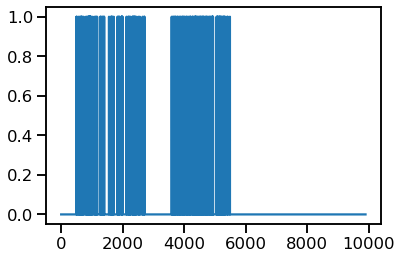

In [640]:
trial = 300
plt.plot(binary[trial])

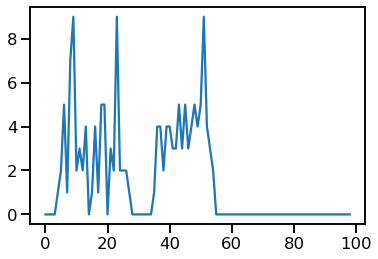

In [641]:
plt.plot(count[trial])

In [317]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * ((x - mu)/sigma)**2)

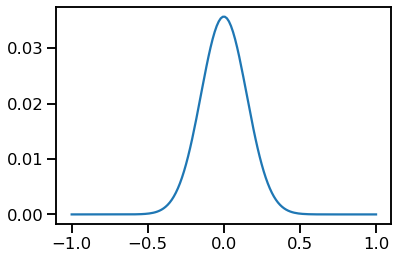

In [352]:
mu = 0
sigma = .150

x = np.linspace(-1.0, 1.0, 150)
kernal = gaussian(x, mu, sigma)
kernal = kernal/np.sum(kernal)
plt.plot(x, kernal)

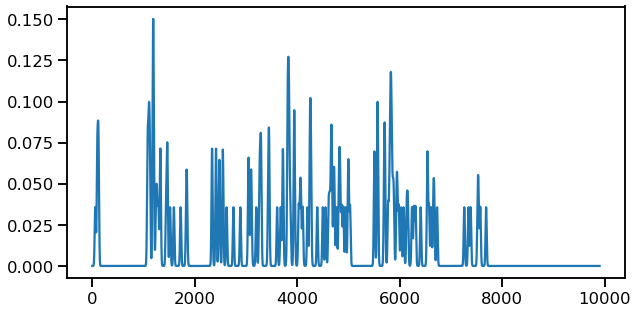

In [448]:
spike_train = tr_spk_binary[5]
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(np.convolve(spike_train, kernal, mode = 'same'))

In [449]:
len(tr_spk_binary[6]), len(np.convolve(spike_train, kernal, mode = 'same'))

(9900, 9900)

In [450]:
conv_trial = []
for trial in tr_spk_binary:
    smoothed =(np.convolve(trial, kernal, mode = 'same'))
    smoothed = np.where(smoothed == 0, np.nan, smoothed)
    conv_trial.append(smoothed)
    
conv_trial = np.array(conv_trial)

In [455]:
test_mean = np.nanmean(conv_trial, axis=0)
test_sem = stats.sem(conv_trial, axis=0, nan_policy='omit')

In [458]:
time = np.linspace(0,9.9, len(test_mean))

[(0.0, 2.0)]

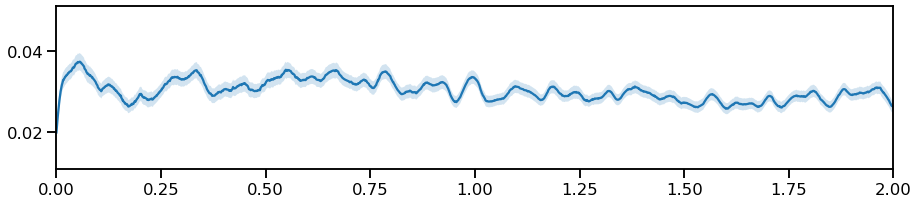

In [462]:
fig, ax = plt.subplots(figsize = (15, 3))
ax.plot(time, test_mean)
ax.fill_between(time, test_mean - test_sem, test_mean + test_sem, alpha = 0.2 )
ax.set(xlim =(0,2))

In [50]:
# Initialize info for plotting
hit_df = beh_df[(beh_df['hit_hist'] == 'hit')]
aud1_df = hit_df[(hit_df['first_sound'] != 'psycho')]

## Stoped here

In [53]:
bndl_dfs, df_names = deal_with_masking(spks_dict, aud1_df, sess_path, 'aud1_no_psycho', 30000)

Loading existing mask_dict...
Done loading.
ngood, first: 175
ngood, first: 175
ngood, second: 195
ngood, second: 195


In [58]:
# initilaize
events = ['aud1_on']
event_names = ['aud1_on']
window = [-500, 2300]
condition = 'first_sound'

In [298]:
# initilaize
events = ['aud1_on']
windows = [[-1000,2300]]
condition = 'correct_side'

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict)
neuron = NeuroVis(spks_dict['spk_times'][0])

#single neuron debug
window = windows[0]
binsize = 100
df = bndl_dfs[df_names[0]]
phys_start = neuron.spiketimes[0]
phys_end = neuron.spiketimes[-1]
event = events[0]
conditions = 'correct_side'

In [13]:
neuron_rasters = get_neuron_rasters(neurons, events, windows, bndl_dfs, df_names)
neuron_psths = get_neuron_psths(neurons, events, windows, bndl_dfs, df_names, conditions=condition)

In [302]:
if not type(df) is dict:
        df = df.reset_index()
len(np.sum(raster['data'][0], axis = 1)), len(psth['data'][0]['mean'])

(14, 17)

In [176]:
if not type(df) is dict:
    df2 = df.reset_index()
wind = [np.floor(window[0]/binsize) * binsize, np.ceil(window[1]/binsize) * binsize]

In [177]:
trials = dict()
trials[0] = np.where(np.ones(np.size(df[event])))[0]
rasters = {
        'event': event,
        'conditions': conditions,
        'window': window,
        'binsize': binsize,
        'data': {},
    }

In [191]:
for cond_id in trials:
    # Select events relevant to this raster
    selected_events = df[event].iloc[trials[cond_id]]

    raster = []
    
    bin_template = 1e-3 * np.arange(window[0], window[1] + binsize, binsize)
    
    for event_time in selected_events:
        bins = event_time + bin_template



In [196]:
bin_template

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3])

In [195]:
for event_time in selected_events:
    bins = event_time + bin_template
    
    searchsorted_idx = np.sq

[5867.858354 5867.958354 5868.058354 5868.158354 5868.258354 5868.358354
 5868.458354 5868.558354 5868.658354 5868.758354 5868.858354 5868.958354
 5869.058354 5869.158354 5869.258354 5869.358354 5869.458354 5869.558354
 5869.658354 5869.758354 5869.858354 5869.958354 5870.058354 5870.158354
 5870.258354 5870.358354 5870.458354 5870.558354 5870.658354 5870.758354
 5870.858354 5870.958354 5871.058354 5871.158354]


In [212]:
event_time, event_time + 1e-3 * window[0], event_time + 1e-3 * window[1]

(5868.858354, 5867.858354, 5871.158354)